In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from tqdm import tqdm
import joblib
import warnings
from src.category_classification.helper_methods import group_seismic_events, print_distribution, save_binary_classification_dataset

warnings.filterwarnings('ignore')

/home/matimat/.cache/pypoetry/virtualenvs/fo-ml-seismic-classifier-sa3ZJyAr-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42)

In [3]:
DATA_CSV_PATH = "../data/raw/seismic_data.csv"

df = pd.read_csv(DATA_CSV_PATH)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset loaded successfully!
Shape: (788820, 22)

First few rows:


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2000-06-30T23:32:26.660Z,44.2690,146.265000,72.900,4.9,mb,10.0,NaN,NaN,0.84,...,2014-11-07T01:10:26.358Z,"39 km NE of Otrada, Russia",earthquake,NaN,7.80,NaN,1.0,reviewed,us,us
1,2000-06-30T22:36:47.300Z,-39.2300,177.470000,36.000,3.4,ml,14.0,NaN,NaN,NaN,...,2014-11-07T01:10:26.356Z,"23 km SSE of Wairoa, New Zealand",earthquake,NaN,NaN,NaN,NaN,reviewed,wel,wel
2,2000-06-30T22:33:48.400Z,50.6660,6.124000,12.600,2.6,ml,8.0,NaN,NaN,NaN,...,2014-11-07T01:10:26.354Z,"0 km ESE of Raeren, Belgium",earthquake,NaN,NaN,NaN,NaN,reviewed,ldg,ldg
3,2000-06-30T22:19:02.440Z,46.7495,-122.806333,6.287,2.7,md,25.0,66.0,0.3629,0.19,...,2016-07-23T00:01:11.860Z,"7 km SE of Bucoda, Washington",explosion,0.028,0.11,0.03,5.0,reviewed,uw,uw
4,2000-06-30T20:33:42.010Z,37.3990,141.503000,42.100,5.4,mwc,216.0,NaN,NaN,0.90,...,2022-04-29T18:43:13.619Z,"45 km ESE of Namie, Japan",earthquake,NaN,NaN,NaN,NaN,reviewed,us,hrv


In [4]:
print(type(df['type']))
print(type(df))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [5]:
print("\nTarget Variable Distribution:")
print(df['type'].value_counts())
print(f"\nNumber of unique event types: {df['type'].nunique()}")


Target Variable Distribution:
type
earthquake                781685
explosion                   4272
mining explosion            2201
ice quake                    208
rock burst                   134
other event                  119
volcanic eruption             93
quarry blast                  59
mine collapse                 14
nuclear explosion             11
experimental explosion         9
sonic boom                     6
landslide                      3
Landslide                      2
acoustic noise                 1
Rock Slide                     1
collapse                       1
Ice Quake                      1
Name: count, dtype: int64

Number of unique event types: 18


In [6]:
print("Creating grouped classification target...")
df['type_grouped'] = df['type'].apply(group_seismic_events)

# Check distribution
print_distribution(df, 'type_grouped')


# pl.DataFrame(df).write_csv("../data/raw/seismic_data_final.csv")

Creating grouped classification target...



Distribution for 'type_grouped':
earthquake: 781,685 (99.10%)
explosion: 6,552 (0.83%)
natural_event: 221 (0.03%)
mining_activity: 148 (0.02%)
other: 121 (0.02%)
volcanic: 93 (0.01%)


In [7]:
df_earthquakes = df[df['type_grouped'] == 'earthquake']
df_non_earthquakes = df[df['type_grouped'] != 'earthquake']

print(f"\nOriginal earthquake samples: {len(df_earthquakes):,}")
print(f"Non-earthquake samples: {len(df_non_earthquakes):,}")

df_earthquakes_sampled = df_earthquakes.sample(n=10000, random_state=42)

print(f"Sampled earthquake samples: {len(df_earthquakes_sampled):,}")

df_balanced = pd.concat([df_earthquakes_sampled, df_non_earthquakes], ignore_index=True)

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nTotal samples after downsampling: {len(df_balanced):,}")




Original earthquake samples: 781,685
Non-earthquake samples: 7,135
Sampled earthquake samples: 10,000

Total samples after downsampling: 17,135


In [8]:
print_distribution(df_balanced, 'type_grouped')


Distribution for 'type_grouped':
earthquake: 10,000 (58.36%)
explosion: 6,552 (38.24%)
natural_event: 221 (1.29%)
mining_activity: 148 (0.86%)
other: 121 (0.71%)
volcanic: 93 (0.54%)


CREATING BINARY CLASSIFICATION DATASET

Binary Target Distribution:
target
0     7135
1    10000
Name: count, dtype: int64

Detailed breakdown:
  0 (non-earthquake): 7,135 samples (41.64%)
  1 (earthquake):     10,000 samples (58.36%)


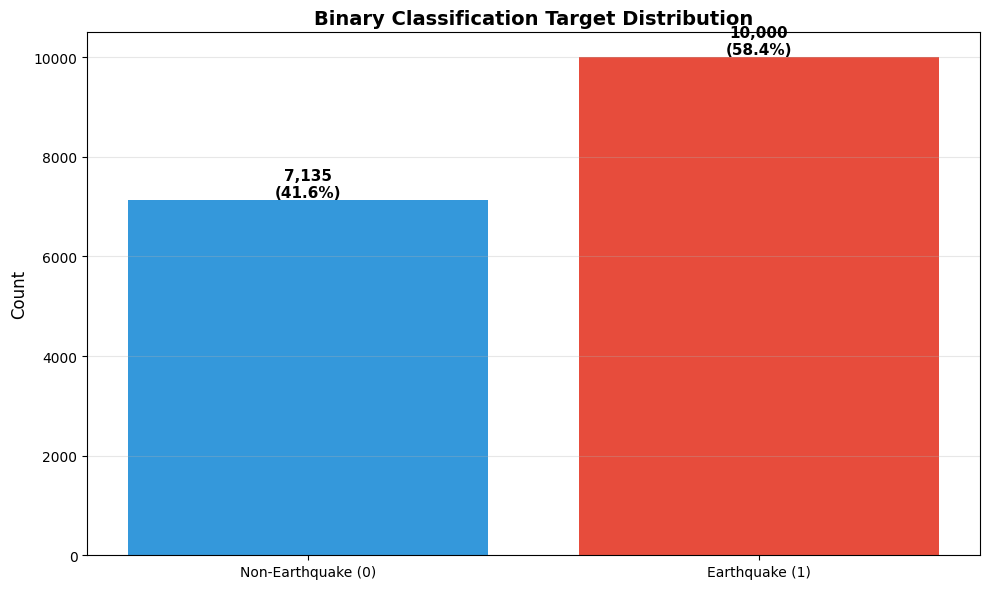


SAVING BINARY DATASET
✓ Binary dataset saved to: ../data/raw/seismic_data_binary.csv
✓ Total rows: 17,135
✓ Columns: ['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource', 'type_grouped', 'target']
✓ Target column 'target' added (0=non-earthquake, 1=earthquake)

SAMPLE DATA (first 5 rows)
   target   mag   depth   nst    gap   longitude   latitude             id
0       0  3.10   0.000   NaN   33.0 -105.279200  43.782800     usc000tk6r
1       0  2.70   0.000  10.0  118.0 -105.348200  43.784100     us6000j9s0
2       1  2.91  10.000   6.0  317.0  -67.296800  19.245100   pr2019273033
3       0  3.20   0.000  30.0   70.6 -105.194000  43.805000  rusms00004827
4       1  2.53   3.743  80.0   53.0 -120.917167  36.344833     nc71909166


In [9]:
from src.category_classification.helper_methods import save_binary_classification_dataset
df_binary = save_binary_classification_dataset(
    df_balanced, 
    output_path="../data/raw/seismic_data_binary.csv"
)